In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score, f1_score
import seaborn as sb
from imblearn.under_sampling import RandomUnderSampler

Data source: https://github.com/saurabhmathur96/clickbait-detector/tree/master/data

# Project variables

In [23]:
m_name = "clickbait v3_channel"
p_dir = os.path.join("../cb models", m_name)

In [24]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [25]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [26]:
create_dir(p_dir)
clear_dir(p_dir)

# Prepare dataset

In [27]:
c1 = pd.read_csv("../cb models/clickbait.txt", names=["title"])
c1["clickbait"] = 1
print("Anzahl clickbait:", c1.shape)
c2 = pd.read_csv("../cb models/no-clickbait.txt", names=["title"])
c2["clickbait"] = 0
print("Anzahl nicht clickbait:", c2.shape)
df = pd.concat([c1.reset_index(drop=True), c2.reset_index(drop=True)], axis=0)
print("Shape before title cleansing:", df.shape)
df = df.loc[df.title.str.len() <= 100, :]
print("Shape after title cleansing:", df.shape)

Anzahl clickbait: (5467, 2)
Anzahl nicht clickbait: (6080, 2)
Shape before title cleansing: (11547, 2)
Shape after title cleansing: (11431, 2)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11431 entries, 0 to 6079
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      11431 non-null  object
 1   clickbait  11431 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 267.9+ KB


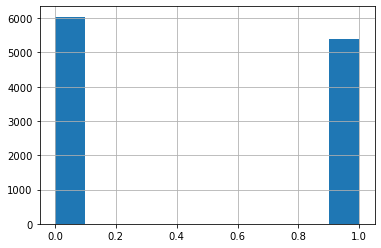

In [29]:
df["clickbait"].hist()
plt.show()

In [30]:
g = df.groupby(["clickbait"]).agg({"title": "count"})
g.rename(columns={"title": "Anzahl"}, inplace=True)
g.head()

,Anzahl
clickbait,
0,6044
1,5387


In [31]:
x = df.loc[:, [c for c in df.columns if c != "clickbait"]]
y = df["clickbait"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
# x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
# y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_test.shape[0])

9144 2287


# Build the model

In [32]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [33]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [35]:
x_train_pp = preprocess_data(x_train)
x_test_pp = preprocess_data(x_test)

In [36]:
pt_model = "distilbert-base-uncased"
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [37]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                       return_token_type_ids=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [38]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states=False
transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)

model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [39]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.0005), 
              metrics=["accuracy"])

In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 100)     327600      tf_distil_bert_model_1[0][0

In [41]:
x_train_tok = tokenize(x_train_pp, tok)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

batch_size = 64
n_epochs = 20

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_test_tok[:2], y_test_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

2021-12-29 08:13:02.850993: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
  1/143 [..............................] - ETA: 23:07 - loss: 0.7542 - accuracy: 0.3906

2021-12-29 08:13:12.467400: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


143/143 [==============================] - 85s 527ms/step - loss: 0.3175 - accuracy: 0.8620 - val_loss: 0.2917 - val_accuracy: 0.8767

Epoch 00001: val_loss improved from inf to 0.29169, saving model to ../cb models/clickbait v3_channel/clickbait v3_channel
Epoch 2/20
143/143 [==============================] - 73s 512ms/step - loss: 0.2275 - accuracy: 0.9058 - val_loss: 0.2276 - val_accuracy: 0.9073

Epoch 00002: val_loss improved from 0.29169 to 0.22760, saving model to ../cb models/clickbait v3_channel/clickbait v3_channel
Epoch 3/20
143/143 [==============================] - 73s 512ms/step - loss: 0.2030 - accuracy: 0.9154 - val_loss: 0.2424 - val_accuracy: 0.8990

Epoch 00003: val_loss did not improve from 0.22760
Epoch 4/20
143/143 [==============================] - 73s 512ms/step - loss: 0.1893 - accuracy: 0.9194 - val_loss: 0.2127 - val_accuracy: 0.9156

Epoch 00004: val_loss improved from 0.22760 to 0.21269, saving model to ../cb models/clickbait v3_channel/clickbait v3_channel

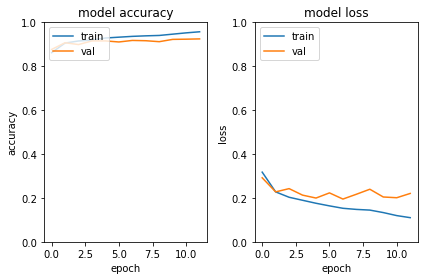

In [42]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Confusion matrix

In [43]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Training data (in-sample)

In [52]:
x_train_tok = tokenize(x_train_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)

y_train_prob = model.predict(x_train_tok[:2], steps=y_train_b.shape[0])
y_pred = np.argmax(y_train_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

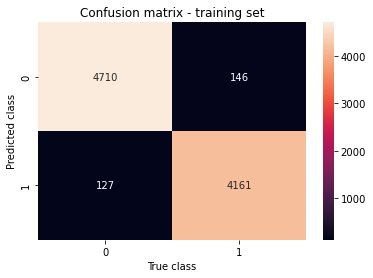

Accuracy: 0.97
Micro precision: 0.97
Micro recall: 0.97
Micro F1-score: 0.97
Macro precision: 0.97
Macro recall: 0.97
Macro F1-score: 0.97
Weighted precision: 0.97
Weighted recall: 0.97
Weighted F1-score: 0.97


In [53]:
cmtx = confusion_matrix(y_train, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - training set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_train.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_train, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_train, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_train, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="weighted")))

## Test data (out-of-sample)

In [54]:
x_test_pp = preprocess_data(x_test)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

y_test_prob = model.predict(x_test_tok[:2], steps=y_test_b.shape[0])
y_pred = np.argmax(y_test_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

In [55]:
print("F1 score: {:0.2f}".format(f1_score(y_test_b, y_pred)))

F1 score: 0.92


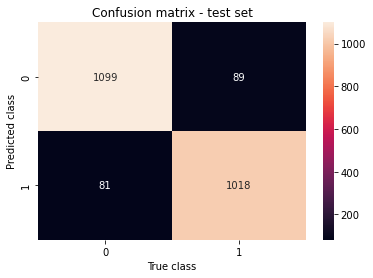

Accuracy: 0.93
Micro precision: 0.93
Micro recall: 0.93
Micro F1-score: 0.93
Macro precision: 0.93
Macro recall: 0.93
Macro F1-score: 0.93
Weighted precision: 0.93
Weighted recall: 0.93
Weighted F1-score: 0.93


In [56]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_test.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

# print(classification_report(y_test, y_pred, target_names=lb.classe_))

# ROC curve

## Training data (in-sample)

In [57]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_train_no = lb.fit_transform(y_train)
y_pred_no = y_train_prob[:, 1]
fpr, tpr, thr = roc_curve(y_train_no, y_pred_no)

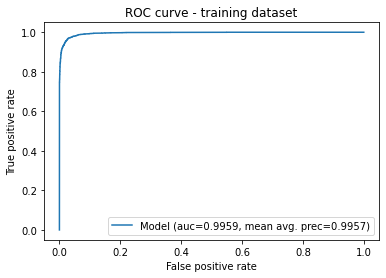

In [58]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_train_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - training dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_train.jpg"))
plt.show()

## Test data (out-of-sample)

In [59]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_test_no = lb.fit_transform(y_test)
y_pred_no = y_test_prob[:, 1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

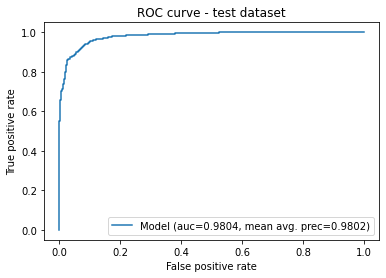

In [60]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_test.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

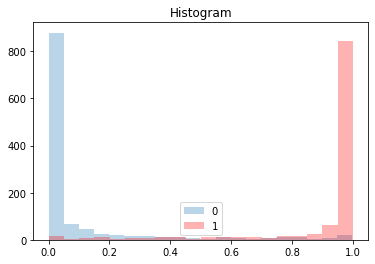

In [61]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(lb.classes_)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

# Sample titles

In [62]:
combo = pd.concat([x_test, y_test], axis=1)
combo.reset_index(drop=True, inplace=True)
combo = pd.concat([combo, pd.Series(y_pred, name="pred")], axis=1)
combo.rename(columns={"clickbait": "truth"}, inplace=True)
combo.shape

(2287, 3)

In [63]:
g = combo.groupby(["pred"], as_index=False).apply(lambda x: x.sample(5, random_state=682))
g[["title", "pred"]].head(10)
g.to_csv(os.path.join(p_dir, "titles.csv"), index=False)
g.head(10)

title  truth  pred
0 2279  Politics and protocol leave Indian teen's life...      0     0
  904   Neighbourhood mourns murder of five of family ...      0     0
  1947  Experts stress on recycling plastic rather tha...      0     0
  1764     Day 2 as US President: Trump says love you CIA      1     0
  893   Everton beat Crystal Palace 1-0 to keep Sam Al...      0     0
1 1937         Can We Guess Your Favourite Movie Of 2014?      1     1
  2050               Ohio Governor Vetoes "Heartbeat Bill      1     1
  211    These 23 Sarcastic People Are Taking The Worl...      1     1
  1908   This Mercedes Is Covered In Millions Of Swaro...      1     1
  1609   7 Amazing Ways To Reuse Old Plastic Bottles. ...      1     1

# Save test set pred

In [64]:
y_pred_test = pd.Series(y_pred, name="y_pred_test")
y_pred_test.to_pickle(os.path.join(p_dir, "y_pred_test.pkl"))

# Apply model on Youtube data

In [1]:
import pandas as pd
import os
import numpy as np

In [6]:
# m_dir = r"../nlp models/distilbert_2_classes_v3_channel"
m_dir = r"../combo models/combo model v3_channel"

combo = pd.read_pickle(os.path.join(m_dir, "combo.pkl"))

x_alien = combo.loc[:, [c for c in combo.columns if c != "qtl"]]
y_alien = combo.loc[:, "qtl"]

In [7]:
x_alien.shape

(10328, 17)

In [44]:
x_alien_pp = preprocess_data(x_alien)
x_alien_tok = tokenize(x_alien_pp, tok)

y_alien_prob = model.predict(x_alien_tok[:2], steps=y_alien.shape[0])
y_pred = np.argmax(y_alien_prob, axis=1)

In [45]:
x_combo = pd.concat([x_alien.reset_index(), y_alien.reset_index(), pd.Series(y_pred, name="pred")], axis=1)

In [46]:
x_combo[["title", "qtl", "pred"]].iloc[412:418, :]

,title,qtl,pred
412,Grey Tries to Get Back into Magic: The Gathering,low,0
413,Grey Plays: Myst,low,0
414,A Crime Against Childhood,very high,0
415,Grey Plays Minecraft,high,0
416,Metric Paper,very high,0
417,Ten Years Later,high,1


In [55]:
x_combo["y"] = (x_combo["qtl"].isin(["very high", "high"])).astype("int32")
x_combo["y"].corr(x_combo["pred"])

0.15230178365072627

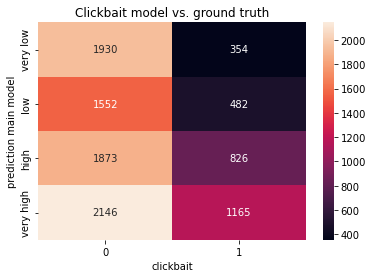

In [56]:
g = x_combo.groupby(["qtl", "pred"]).agg({"title": "count"}).reset_index()
g.rename(columns={"pred": "clickbait", "title": "count"}, inplace=True)
p = g.pivot(index="qtl", columns="clickbait", values="count")
sb.heatmap(p, annot=True, fmt="d")
plt.title("Clickbait model vs. ground truth")
plt.xlabel("clickbait")
plt.ylabel("prediction main model")
plt.savefig(os.path.join(p_dir, "confusion matrix clickbait vs ground truth.jpg"))
plt.show()

In [49]:
x_combo.loc[(x_combo["qtl"] == "very high") & (x_combo["pred"] == 0), "title"].head(10)

2     How Does A Carburetor Work? | Transparent Carb...
3     How Does Film ACTUALLY Work? (It's MAGIC)  [Ph...
10    How Do Nuclear Submarines Make Oxygen?- Smarte...
12    How Sonar Works (Submarine Shadow Zone) - Smar...
13    How to Harvest Pecans (In Slow Motion) - Smart...
15    How to Make Pizza on a Submarine - Smarter Eve...
17    How to Fight Fire or Flooding on a Nuclear Sub...
20    Crawling Down A Torpedo Tube -US NAVY Nuclear ...
21    Boarding a US NAVY NUCLEAR SUBMARINE in the Ar...
23    Which Shape CUTS BEST? (Weed Eater Line at 100...
Name: title, dtype: object

Why is the correlation not higher?

* Video thumbnails and titles can be changed over the lifetime of a Youtube video
* This might be related to the sample being from science/educational video. The typical viewer seems to also be attracted by videos clearly stating their content (Derek Muller also mentions such as case -> lava lamp video). May be because he is looking for something specific or because she is interested in the topic anyway.

In [50]:
x_combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10328 entries, 0 to 10327
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   index               10328 non-null  int64              
 1   id_video            10328 non-null  object             
 2   title               10328 non-null  object             
 3   channel_id          10328 non-null  object             
 4   channel_name        10328 non-null  object             
 5   published_video     10328 non-null  datetime64[ns, UTC]
 6   like_count          10328 non-null  float64            
 7   dislike_count       10328 non-null  float64            
 8   view_count_video    10328 non-null  float64            
 9   published_mth       10328 non-null  int64              
 10  title_len           10328 non-null  int64              
 11  id_channel          10328 non-null  object             
 12  view_count_channel  10328 non-nu

In [57]:
g = x_combo.groupby(["channel_name"]).agg({"id_video": "count", "pred": "sum", "y": "sum"}).reset_index()
g.rename(columns={"id_video": "video_count", "pred": "clickbait", "y": "very high"}, inplace=True)
g["vh_ratio"] = g["very high"] / g["video_count"]
g["cb_ratio"] = g["clickbait"] / g["video_count"]

In [58]:
lbl = ["very low", "low", "high", "very high"]
g["success class"] = pd.cut(g["vh_ratio"], 4, labels=lbl)

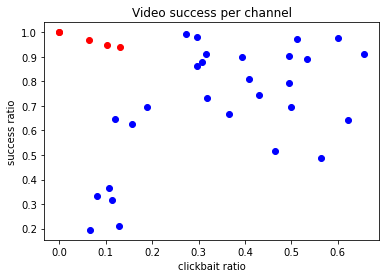

In [59]:
# c = ["red", "orange", "green", "blue"]
# i = 0
# for l in lbl:
#     plt.scatter(g.loc[g["success class"] == l, "cb_ratio"], g.loc[g["success class"] == l, "vh_ratio"], c=c[i])
#     i += 1
plt.scatter(g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "cb_ratio"], g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "vh_ratio"], c="red")
plt.scatter(g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"], g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "vh_ratio"], c="blue")
plt.xlabel("clickbait ratio")
plt.ylabel("success ratio")
plt.title("Video success per channel")
plt.savefig(os.path.join(p_dir, "channel level corr clickbait vs video success.jpg"))
plt.show()

In [60]:
g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "cb_ratio"].count()

5

In [61]:
c = g["cb_ratio"].corr(g["vh_ratio"])
print("{:0.2f}".format(c))

0.22


In [62]:
sp = g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), :]
sp.sort_values(["vh_ratio", "cb_ratio"], ascending=True).head(10)

,channel_name,video_count,clickbait,very high,vh_ratio,cb_ratio,success class
0,3Blue1Brown,115,15,108,0.939130,0.130435,very high
14,PBS Space Time,292,30,277,0.948630,0.102740,very high
21,ScienceClic English,31,2,30,0.967742,0.064516,very high
13,OverSimplified,26,0,26,1.000000,0.000000,very high
17,Primer,14,0,14,1.000000,0.000000,very high


Removing the 2 channels with a clickbait ratio of 0 but at the same time being super successful

In [63]:
g.loc[(g["cb_ratio"] == 0), "channel_name"]

13    OverSimplified
17            Primer
Name: channel_name, dtype: object

In [64]:
c = g.loc[(g["cb_ratio"] > 0), "cb_ratio"].corr(g.loc[(g["cb_ratio"] > 0), "vh_ratio"])
print("{:0.2f}".format(c))

0.38


In [65]:
c2 = g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"].corr(
    g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "vh_ratio"])
print("{:0.2f}".format(c2))

0.58


In [66]:
g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"].count()

28